# Simple NN


In [6]:
import sys
# sys.path.append("/home/arseni1919/PycharmProjects/NT_sandbox")
# sys.path.append("/Users/arseniperchik/PycharmProjects/NT_sandbox")

print(sys.path)
from IMPORTS import *
from simple_nn import *

%matplotlib inline
%config Completer.use_jedi = False
# print(sys.path)

['/Users/arseniperchik/PycharmProjects/NT_sandbox/NN', '/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python37.zip', '/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python3.7', '/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python3.7/lib-dynload', '', '/Users/arseniperchik/.local/lib/python3.7/site-packages', '/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python3.7/site-packages', '/Users/arseniperchik/PycharmProjects/gym-stocktrading', '/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python3.7/site-packages/IPython/extensions', '/Users/arseniperchik/.ipython', '/home/arseni1919/PycharmProjects/NT_sandbox', '/Users/arseniperchik/PycharmProjects/NT_sandbox', '/Users/arseniperchik/PycharmProjects/NT_sandbox']


# Some Function

/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

divide by zero encountered in log



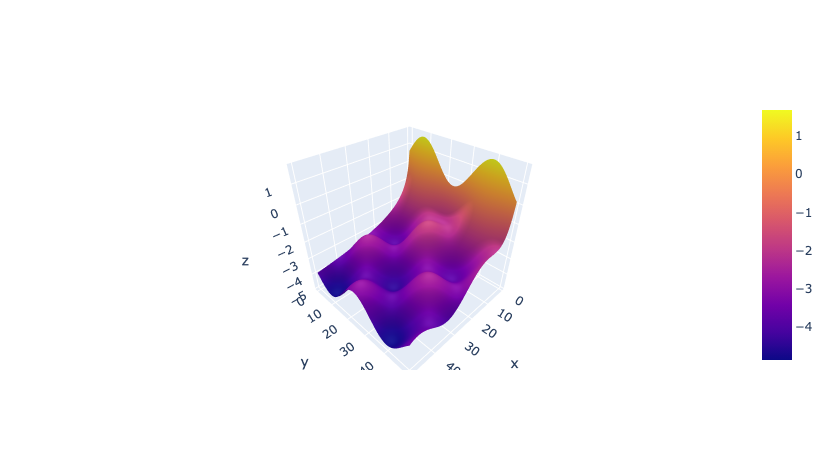

In [8]:
scale = 50.0
x = np.linspace(0.0, scale, num=100)
y = np.linspace(0.0, scale, num=100)
z = np.zeros((len(x),len(y)))

def y_func(a, b):
    return np.sin( a / 5) * np.cos( b / 5) - np.log(b)
    
for i_indx, i in enumerate(x):
    for j_indx, j in enumerate(y):
#         z[i,j] = np.log(i) + np.log(j)
        z[i_indx,j_indx] = y_func(i, j)
#         z[i_indx,j_indx] = np.sin(10*(i**2+j**2))/10.0

fig = go.Figure(
    data=go.Surface(x=x,y=y,z=z)
)
fig

In [3]:
class ALGLightningModule(pl.LightningModule):

    def __init__(self, input_size, output_size):
        super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_size, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             # nn.Linear(128, 128),
#             # nn.ReLU(),
#             nn.Linear(128, output_size),
#             nn.ReLU(),
#         )
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
#         return self.net(x.view(x.size(0), -1))
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

#         self.log('current total reward', self.total_reward)
        self.log('train loss', loss)
        # self.log('epsilon', epsilon)
        # if batch_idx % 1000 == 0:
        #     print(epsilon)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)

In [8]:

PARAMS = {'LR': LR}
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTBjYmViMGYtN2Q0ZC00NWEyLWE3OTItM2NlODg0Yjc4M2M0In0=",
    project_name="1919ars/NA-sandbox",
    params=PARAMS)

NeptuneLogger will work in online mode


In [14]:
from torchvision.datasets import MNIST

train_loader = DataLoader(MNIST(os.getcwd(), download=True, transform=transforms.ToTensor()))
model = ALGLightningModule(input_size=28 * 28, output_size=10)

trainer = pl.Trainer(logger=neptune_logger)
# trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
